# VisionEcho Project:Image-to-Speech for the Blind
In this project, we need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.



This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.


- The project is an extended application of Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper.

## Step 1 : Lets Import required Libraries

In [1]:
#Import all the required libraries
!pip install pandas seaborn scikit-learn tqdm nltk numpy
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import os
pd.set_option('display.max_colwidth',100)




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


2025-05-18 09:56:17.915114: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 2: Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
DATA_DIR = './data/'
IMAGES_DIR = os.path.join(DATA_DIR, 'Images')
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions.txt')
OUTPUT_IMAGE_PATH = './output/images/'

# Ensure output directory exists
os.makedirs(OUTPUT_IMAGE_PATH, exist_ok=True)

all_imgs = glob.glob(os.path.join(IMAGES_DIR, '*.jpg'), recursive=True)
print(f"The total images present in the dataset: {len(all_imgs)}")


The total images present in the dataset: 8091


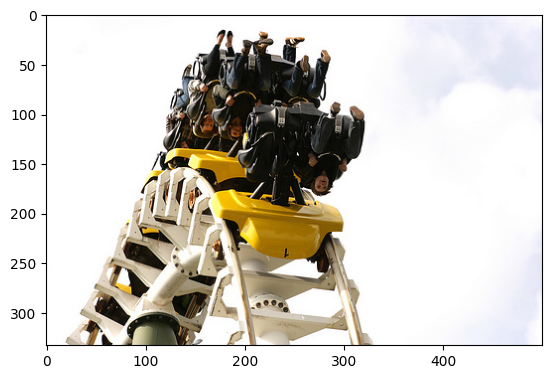

In [3]:
#Visualise both the images & text present in the dataset
plt.imshow(mpimg.imread(all_imgs[109]))
plt.show()

In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):

    #your code here
    with open(filename,'r') as f:
        text=list(filter(None,(line.rstrip() for line in f)))

    return text

doc = load_doc(CAPTIONS_FILE)
print(doc[:5])

['image,caption', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']


Lets Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset will have 40455 samples.

In [5]:
all_img_id=[i.split(',')[0] for i in doc[1:]] #store all the image id here
all_img_vector=[os.path.join(IMAGES_DIR,i.split(',')[0]) for i in doc[1:]] #store all the image path here
annotations=[i.split(',')[1] for i in doc[1:]] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,./data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,./data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,./data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,./data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...,...
40450,997722733_0cb5439472.jpg,./data/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,./data/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,./data/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,./data/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [6]:
#Lets Create a list which contains all the captions


#add the <start> & <end> token to all those captions as well
annotations=df.Captions.apply(lambda x:'<start> '+x+' <end>').to_list()
#Lets Create a list which contains all the path to the images
all_img_path=df.Path.to_list()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [7]:
#Lets Create the vocabulary & the counter for the captions

vocabulary=[] #write your code here
for cap in df.Captions.values:
    vocabulary.extend(cap.split())
val_count=Counter(vocabulary)
val_count

Counter({'a': 38716,
         '.': 34205,
         'A': 21480,
         'in': 18170,
         'the': 14587,
         'on': 10354,
         'is': 9069,
         'and': 8057,
         'dog': 7804,
         'with': 7303,
         'man': 6727,
         'of': 6495,
         'Two': 3962,
         'white': 3646,
         'black': 3491,
         'boy': 3395,
         'are': 3364,
         'girl': 3174,
         'woman': 3146,
         'to': 3005,
         'The': 2919,
         'wearing': 2916,
         'at': 2809,
         'water': 2671,
         'red': 2542,
         'young': 2411,
         'people': 2397,
         'brown': 2383,
         'his': 2255,
         'blue': 2116,
         'dogs': 2055,
         'running': 1995,
         'through': 1978,
         'playing': 1954,
         'an': 1870,
         'while': 1807,
         'down': 1755,
         'shirt': 1735,
         'standing': 1702,
         'ball': 1678,
         'little': 1607,
         'grass': 1565,
         'child': 1449,
        

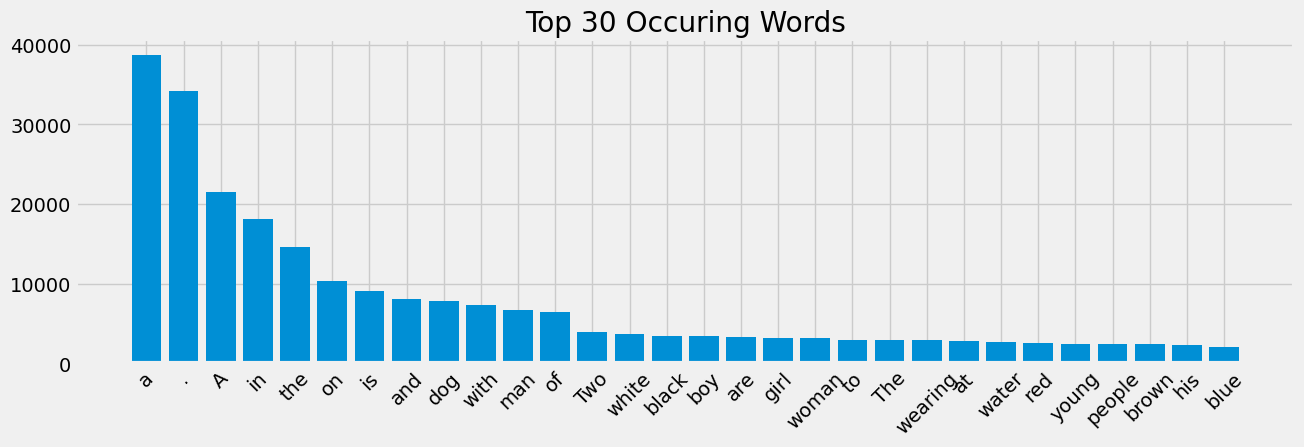

In [8]:
#Visualise the top 30 occuring words in the captions
def plot_top_words(word_counter):
    plt.style.use('fivethirtyeight')
    # plt.title('Most Commonly Used NOUNs')
    plt.figure(figsize=(14,4))
    plt.xticks(rotation=45)
    # plt.bar(*zip(*word_counter.most_common(30)))
    plt.bar(*zip(*word_counter))
    plt.title("Top 30 Occuring Words")
    plt.show()

plot_top_words(val_count.most_common(30))

## Step 3: Pre-Processing the captions
1.We create a tokenized vectors by tokenizing the captions for ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [9]:
# create the tokenizer

top_word_count = 5000

filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])
print(f'OOV Token: {tokenizer.oov_token}')


[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4], [3, 2, 20, 313, 64, 2, 197, 120, 4], [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4], [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4], [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']
OOV Token: <unk>


In [10]:
# Lets Create a word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Add Pad Token
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


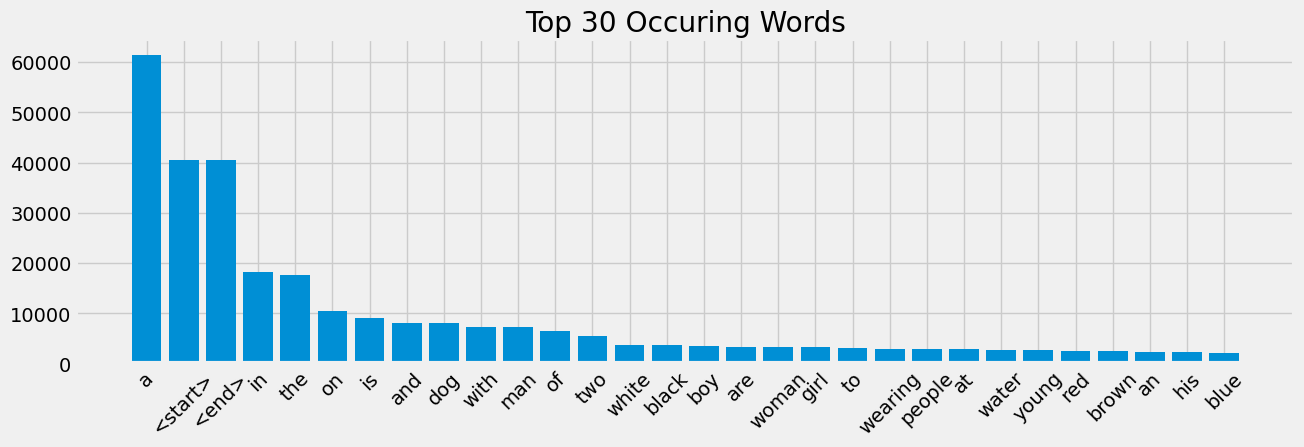

In [11]:
# Lets Create a word count of our tokenizer to visulize the Top 30 occuring words after text processing
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
plot_top_words(sort_word_by_count[:30])

In [12]:
# Pad each vector to the max_length of the captions & store it to a vairable

max_sequence_len = max(len(t) for t in train_seqs)
print(f'Max Sequence Length of the Texts is: {max_sequence_len}')

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sequence_len)
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max Sequence Length of the Texts is: 35
The shape of Caption vector is :(40455, 35)


## Step 4: Pre-processing the images

1.Resize images into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

#### Tips to resize the images::
* Since we have a list which contains all the image path, we need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once we have created a dataset consisting of image paths, we need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [13]:
#lets create the dataset consisting of image paths
unique_img_vector = sorted (set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_vector)


In [14]:
#Code for creating the function. This function should return images & their path

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


In [15]:
#Applying the function to the image path dataset, such that the transformed dataset should contain images & their path

image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                .batch(64)
image_dataset



<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Step 5: Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, we extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.We Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [16]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input =image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model =tf.keras.Model(new_input, hidden_layer)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 50s 1us/step 


In [17]:
# Applying the feature_extracted model to our earlier created dataset which contained images & their respective paths
# Once the features are created, we reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                  (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())


2025-05-18 10:05:09.891083: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [07:51<00:00,  3.71s/it]


## Step 6: Dataset creation
1.Applying train_test_split on both image path & captions to create the train & test list. Creating the train-test split using 80-20 ratio & random state = 42

2.Lets Create a function which maps the image path to their feature.

3.lets Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

4.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

5.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [18]:
#Lets split the data

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [19]:
# Checking the shape of train and Test data
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [20]:
# Lets Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image, caption):
    img_tensor = np.load(image.decode('utf-8')+'.npy')
    return img_tensor,caption

### Tips on how to load the features:
* We can load the features using the dictionary created earlier OR
* We can store using numpy(np.load) to load the feature vector.

In [21]:
# Lets create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image, caption,batch_size = 32,buffer_size=1000):

    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset



In [22]:
BATCH_SIZE=64
train_dataset=gen_dataset(path_train,cap_train,BATCH_SIZE)
test_dataset=gen_dataset(path_test,cap_test)

In [23]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


##  Step 7: Model Building
1.Set the parameters

2.Lets Build the Main : Encoder, Attention model & Decoder

In [24]:
#Set train and test Steps
embedding_dim = 256
units = 512
vocab_size =5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Defining Encoder

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim = 256):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation

    def call(self, features):
        features =  self.dense(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [26]:
encoder=Encoder(embedding_dim)

### Defining Attention model

In [27]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)


        return context_vector, attention_weights

###  Defining Decoder

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [29]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [30]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Step 8: Model training & optimization
1.Lets Set the optimizer & loss object

2.Create our checkpoint path

3.Create our training & testing step functions

4.Create our loss function for the test dataset

In [31]:
# We will use Adam Optimizer
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [32]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [33]:
# Creating Checkpoints
# checkpoint_path = "./checkpoints/train"
checkpoint_path = os.path.join("checkpoints","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [34]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for our model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [35]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))


    return loss, avg_loss

* While creating the test step for our model, we will pass our previous prediciton as the next input to the decoder.

In [36]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
    #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            predicted_id = tf.argmax(predictions,1)
            dec_input = tf.expand_dims(predicted_id, 1)

    avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [37]:
def test_loss_cal(test_dataset):
    total_loss = 0


    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss,t_loss = test_step(img_tensor,target)
        total_loss += t_loss
    return total_loss/test_num_steps

In [ ]:
import time
from tqdm import tqdm

EPOCHS = 1
best_test_loss = float('inf')
loss_history = {'train': [], 'test': []}

# Debugging setup
debug_log = []
startup_time = time.time()

print("=== Starting training session ===")
print(f"Initial startup time: {time.time() - startup_time:.2f}s")

for epoch in tqdm(range(EPOCHS), desc='Training'):
    epoch_start = time.time()
    total_train_loss = 0
    batch_counter = 0  # Debug counter
    
    print(f"\n=== Epoch {epoch+1} ===")
    debug_log.append(f"Epoch {epoch+1} started at {time.strftime('%H:%M:%S')}")

    # Training phase with debug checks
    try:
        for batch, (img_tensor, target) in enumerate(train_dataset):
            batch_counter += 1
            
            # Debug: Verify batch data
            if batch == 0:  # Only check first batch to avoid spam
                print(f"\nFirst batch debug:")
                print(f"  Image tensor shape: {img_tensor.shape}")
                print(f"  Target shape: {target.shape}")
                print(f"  Image range: {tf.reduce_min(img_tensor):.3f} to {tf.reduce_max(img_tensor):.3f}")
                debug_log.append(f"Epoch {epoch+1} batch 0 shapes: img={img_tensor.shape}, target={target.shape}")
            
            # Train step with timing
            batch_start = time.time()
            _, batch_loss = train_step(img_tensor, target)
            batch_time = time.time() - batch_start
            
            if batch == 0:  # Log first batch performance
                print(f"  First batch train_step took: {batch_time:.2f}s")
                debug_log.append(f"Epoch {epoch+1} first batch time: {batch_time:.2f}s")
            
            total_train_loss += batch_loss
            
            # Periodic progress report
            if (batch + 1) % 10 == 0:
                print(f"  Completed batch {batch+1}/{train_num_steps} | Avg batch time: {batch_time:.2f}s")
            
        # Calculate metrics
        avg_train_loss = total_train_loss / train_num_steps
        debug_log.append(f"Epoch {epoch+1} avg_train_loss: {avg_train_loss:.3f}")
        
        print("\n=== Calculating test loss ===")
        test_start = time.time()
        current_test_loss = test_loss_cal(test_dataset)
        print(f"Test calculation took: {time.time() - test_start:.2f}s")
        
        # Store results
        loss_history['train'].append(avg_train_loss)
        loss_history['test'].append(current_test_loss)
        
        # Epoch summary
        epoch_time = time.time() - epoch_start
        print(f'\nEpoch {epoch+1}/{EPOCHS} summary:')
        print(f'  Train loss: {avg_train_loss:.3f}  Test loss: {current_test_loss:.3f}')
        print(f'  Time: {epoch_time:.2f}s')
        print(f'  Processed batches: {batch_counter}/{train_num_steps}')
        
        # Checkpointing
        if current_test_loss < best_test_loss:
            print(f'Test loss reduced from {best_test_loss:.3f} to {current_test_loss:.3f}')
            best_test_loss = current_test_loss
            ckpt_manager.save()
            debug_log.append(f"Checkpoint saved at epoch {epoch+1}")
            
    except Exception as e:
        print(f"\n!!! Error during epoch {epoch+1}, batch {batch_counter} !!!")
        print(f"Error type: {type(e).__name__}")
        print(f"Error message: {str(e)}")
        debug_log.append(f"Error in epoch {epoch+1} batch {batch_counter}: {str(e)}")
        break

# Final debug summary
print("\n=== Training completed ===")
print("Debug log summary:")
for entry in debug_log:
    print(f"  {entry}")

print(f"\nTotal training time: {time.time() - startup_time:.2f} seconds")

=== Starting training session ===
Initial startup time: 0.00s


Training:   0%|                                                                                  | 0/2 [00:00<?, ?it/s]


=== Epoch 1 ===

First batch debug:
  Image tensor shape: (64, 64, 2048)
  Target shape: (64, 35)
  Image range: 0.000 to 26.180
  First batch train_step took: 29.84s
  Completed batch 10/505 | Avg batch time: 2.89s
  Completed batch 20/505 | Avg batch time: 2.94s


In [ ]:
# Checking the plot of Loss vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(loss_history['train'], label='Training Loss')
plt.plot(loss_history['test'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), we may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if we want to achieve better results we can run it more epochs, but the intent of this project is to get an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Step 9: Model Evaluation
1.We will define our evaluation function using greedy search

2.We will define our evaluation function using beam search

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
# Using Greedy Search Evaluation method

attention_features_shape = 64

def evaluate(image):
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_sequence_len):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
# Evaluating using Beam Search

def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_sequence_len:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption


In [ ]:
from PIL import Image
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
# Lets check the Verbose of the fitted image and the caption Generated:

def test_caption_generation(img_test):


    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    #test_image = './images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join(
        tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]
    )

    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = [real_caption.split()]
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)

    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))
    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")

    plot_attmap(result, attention_plot, test_image)


    Image.open(test_image)

In [ ]:

test_caption_generation(path_test)

### Evaluation with Unseen Data

In [ ]:
# Install Required Libraries to Convert Text to Audio
!pip install pygame
!pip install gtts
import gtts
import pygame
# Libraries to convert text into audio
from gtts import gTTS
from IPython import display

In [ ]:
# Function to run the model on Test Image
def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    newsize = (800, 800)
    im = Image.open(openImg).resize(newsize)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))



    return im,pred_caption


In [ ]:
a,b=Prediction_Unknown_data(path_test[22])
plt.imshow(mpimg.imread(path_test[22]))
plt.show()

In [ ]:
# make request to google to get synthesis
#Caption to audio conversion
soundFile = 'pred_caption.mp3'

tts = gTTS(b, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))

## Conclusion

"VisionEcho Project:Image-to-Speech for the Blind"

The "VisionEcho Project:Image-to-Speech for the Blind" project represents a remarkable innovation in the field of assistive technology, with a clear mission to provide a voice to those who cannot see. By combining state-of-the-art computer vision and natural language processing techniques, this project bridges the gap between the visual and auditory realms, allowing blind individuals to perceive, interpret, and understand the world around them in ways that were once unimaginable.

Key achievements of this project include:

1. **Encoder-Decoder Architecture**: The project leverages an Encoder-Decoder architecture, a deep learning model that has demonstrated remarkable capabilities in image captioning and language generation. The encoder extracts valuable information from images, while the decoder converts this information into coherent and descriptive spoken language.

2. **Attention Mechanism**: The attention mechanism is integrated into the model, allowing it to focus on relevant parts of an image while generating speech. This enhances the quality and accuracy of the spoken descriptions, ensuring a more detailed and contextually relevant experience for the users.

3. **Accessibility and Inclusivity**: "Eye for the Blind" promotes accessibility and inclusivity, making the world more navigable and comprehensible for the visually impaired. It provides them with a means to explore and understand their surroundings, including scenes, objects, and written text, through auditory feedback.

4. **Empowerment**: The project empowers visually impaired individuals to gain greater independence, education, and employment opportunities. By harnessing technology to deliver real-time spoken descriptions, it facilitates better engagement with the world and improved quality of life.

5. **Continuous Improvement**: The project is a testament to the ever-evolving field of artificial intelligence and its potential to transform lives. It demonstrates a commitment to ongoing research and development to enhance the system's accuracy, reliability, and user-friendliness.

In conclusion, "VisionEcho Project:Image-to-Speech for the Blind" serves as a remarkable example of the positive impact that technology can have on the lives of individuals with visual impairments. It enables them to explore the visual world through auditory senses, breaking down barriers and fostering greater independence. This project underscores the importance of accessibility, innovation, and the profound difference that technology can make in the lives of those it serves.

<h1><center><img src="https://i.pinimg.com/originals/e2/d7/c7/e2d7c71b09ae9041c310cb6b2e2918da.gif"></center></h1>